#LIBRARIES

In [ ]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

import bitermplus as btm
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import jaccard_score

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Exploratory Data Analysis

* Dataset Loading

In [ ]:
temp_df = pd.read_csv('aitools.csv')
temp_df.head()

,tool_mage_url,tool,tool_description,category,upvotes,tags
0,https://uploads-ssl.webflow.com/63994dae103371...,Codeium,"Helps developers understand, modify, and test ...",Generative Code,1987,NaN
1,https://uploads-ssl.webflow.com/63994dae103371...,LeiaPix,Upload an image and turn it into a 3D animation,Image Improvement,1779,Generative Video
2,https://uploads-ssl.webflow.com/63994dae103371...,GPT-3 Playground (OpenAI),Free AI writing tool - Let the AI generate any...,Copywriting,1433,Research
3,https://uploads-ssl.webflow.com/63994dae103371...,BlueWillow,AI-powered image generating tool in Discord,Generative Art,1230,Matt's Picks
4,https://uploads-ssl.webflow.com/63994dae103371...,Character.AI,Have chat conversations with AI characters,Chat,954,For Fun


* Handling missing values

In [ ]:
temp_df.isna().sum()

tool_mage_url         0
tool                  0
tool_description      1
category              0
upvotes               0
tags                626
dtype: int64

* Dropping `tags` because it has almost empty values, this will decrease our model performance

In [ ]:
temp_df.drop('tags', axis=1, inplace=True)

 * Dropping one row which has no `tool_description`

In [ ]:
temp_df.dropna(subset=['tool_description'], inplace=True)

In [ ]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1011 entries, 0 to 1011
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tool_mage_url     1011 non-null   object
 1   tool              1011 non-null   object
 2   tool_description  1011 non-null   object
 3   category          1011 non-null   object
 4   upvotes           1011 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 47.4+ KB


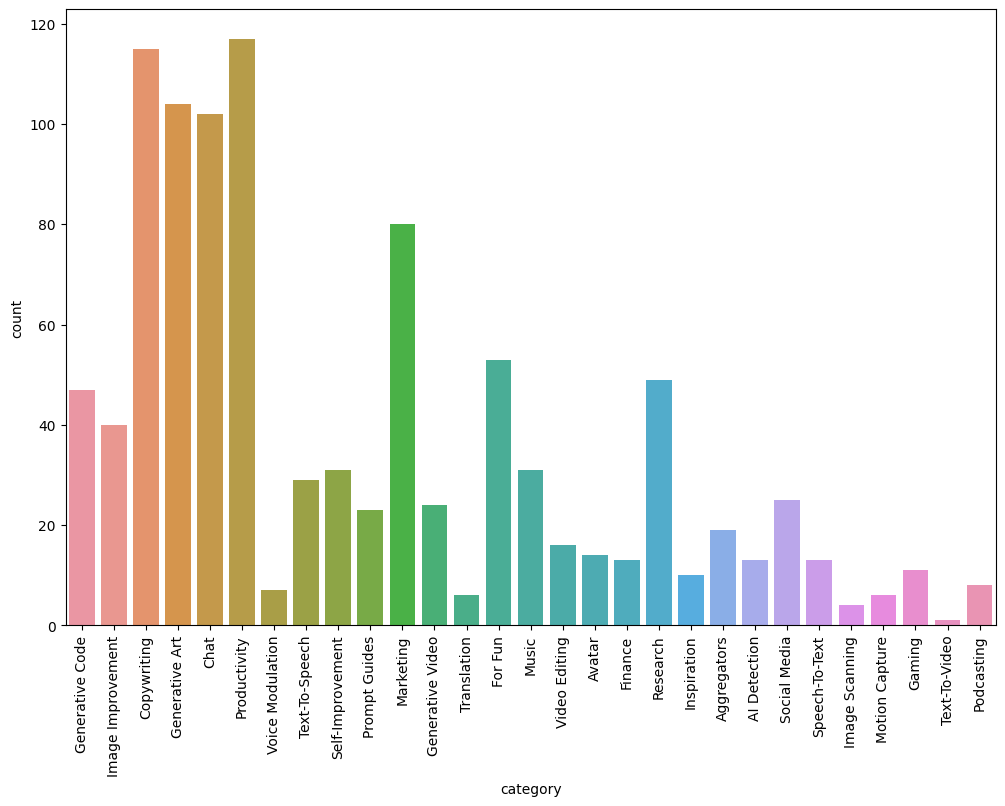

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x=temp_df['category'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(f"Number of Target Classes: {len(temp_df['category'].unique())}")
print(temp_df['category'].unique())

Number of Target Classes: 29
['Generative Code' 'Image Improvement' 'Copywriting' 'Generative Art'
 'Chat' 'Productivity' 'Voice Modulation' 'Text-To-Speech'
 'Self-Improvement' 'Prompt Guides' 'Marketing' 'Generative Video'
 'Translation' 'For Fun' 'Music' 'Video Editing' 'Avatar' 'Finance'
 'Research' 'Inspiration' 'Aggregators' 'AI Detection' 'Social Media'
 'Speech-To-Text' 'Image Scanning' 'Motion Capture' 'Gaming'
 'Text-To-Video' 'Podcasting']


# Data Preprocessing

* Text cleaning

In [ ]:
def clean_text(text):
    text = text.lower()

    text = re.sub(r'\d+', '', text) # remove numbers

    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])

    extended_punctuations = string.punctuation + '’‘“”'
    translator = str.maketrans('', '', extended_punctuations)
    lemmatized_text = lemmatized_text.translate(translator)

    stop_words = set(stopwords.words('english'))
    lemmatized_text = ' '.join([word for word in lemmatized_text.split() if word not in stop_words])

    lemmatized_text = ' '.join(lemmatized_text.split())

    return lemmatized_text




In [ ]:
df = pd.DataFrame()
df['description'] = temp_df['tool_description'].apply(clean_text)

In [ ]:
df.head()

,description
0,help developer understand modify test unfamili...
1,upload image turn animation
2,free ai write tool let ai generate text imagine
3,ai powered image generating tool discord
4,chat conversation ai character


# IMPLEMENTATION OF BDM

* Extracting `biterms`, all vocabulary in dataset, and length of `biterms`

In [ ]:
texts = df['description']
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)

docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))

biterms = btm.get_biterms(docs_vec)

* Adding columns `biterm_indexes`, `biterms`, `length` in dataset

In [ ]:
df['biterm_indexes'] = biterms
df['biterms'] = df['biterm_indexes'].apply(lambda lst, vocab=vocab_dict: [[k for num in inner_lst for k, val in vocab.items() if val == num] for inner_lst in lst])

In [ ]:
df.head()

,description,biterm_indexes,biterms,length
0,help developer understand modify test unfamili...,"[[271, 446], [446, 1086], [446, 621], [446, 10...","[[developer, help], [help, understand], [help,...",10
1,upload image turn animation,"[[471, 1094], [1075, 1094], [34, 1094], [471, ...","[[image, upload], [turn, upload], [animation, ...",4
2,free ai write tool let ai generate text imagine,"[[20, 397], [397, 1155], [397, 1053], [397, 54...","[[ai, free], [free, write], [free, tool], [fre...",9
3,ai powered image generating tool discord,"[[20, 744], [20, 471], [20, 416], [20, 1053], ...","[[ai, powered], [ai, image], [ai, generating],...",6
4,chat conversation ai character,"[[146, 209], [20, 146], [145, 146], [20, 209],...","[[chat, conversation], [ai, chat], [character,...",4


In [ ]:
model = btm.BTM(
    X, vocabulary, seed=12321, T=20, M=100, alpha=0.01, beta=0.01)
model.fit(biterms)

100%|██████████| 600/600 [00:02<00:00, 295.15it/s]


In [ ]:
p_zd = model.transform(docs_vec)

100%|██████████| 1011/1011 [00:00<00:00, 34696.29it/s]


In [ ]:
biterms_list_column = df['biterm_indexes']

p_wz = model.matrix_topics_words_

def calculate_global_weights(biterms_list):
    biterm_probs = []
    for biterm in biterms_list:
        biterm_prob = 0.0
        for topic_probs in p_wz:
            biterm_prob += topic_probs[biterm[0]] * topic_probs[biterm[1]]
        biterm_probs.append(biterm_prob)
    return biterm_probs

df['global_biterm_probs'] = biterms_list_column.apply(calculate_global_weights)


In [ ]:
def calculate_context_aware_weights(row):
    biterms = row['biterm_indexes']
    global_biterm_probs = row['global_biterm_probs']

    if len(biterms) == 0:
        return []

    context_aware_weights = []

    for i, biterm in enumerate(biterms):
        global_weight = global_biterm_probs[i]

        sum_global_weights = sum(global_biterm_probs)

        context_aware_weight = global_weight / sum_global_weights

        context_aware_weights.append(context_aware_weight)

    return context_aware_weights

df['context_aware_weights'] = df.apply(calculate_context_aware_weights, axis=1)

In [ ]:


def calculate_biterm_distance(biterm1, biterm2):
    set1 = set(biterm1)
    set2 = set(biterm2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_distance = 1.0 - (intersection / union)
    return jaccard_distance

def calculate_short_text_distance(weights1, weights2, biterms1, biterms2):

    weights1 = np.array(weights1)
    weights2 = np.array(weights2)

    distances = np.array([[calculate_biterm_distance(b1, b2) for b2 in biterms2] for b1 in biterms1])

    short_text_distance = np.sum(weights1[:, np.newaxis] * weights2 * distances) / np.sum(weights1)
    return short_text_distance


descriptions = df.description.to_list()
biterms = df.biterms.to_list()
context_aware_weights = df.context_aware_weights.to_list()

num_texts = len(descriptions)

distance_matrix = np.zeros((num_texts, num_texts))

for i in range(num_texts):
    for j in range(i + 1, num_texts):
        distance_matrix[i, j] = calculate_short_text_distance(
            context_aware_weights[i], context_aware_weights[j],
            biterms[i], biterms[j]
        )

        distance_matrix[j, i] = distance_matrix[i, j]

print(distance_matrix)


[[0.         1.         1.         ... 0.8864119  1.         1.        ]
 [1.         0.         1.         ... 1.         1.         1.        ]
 [1.         1.         0.         ... 1.         1.         0.71820893]
 ...
 [0.8864119  1.         1.         ... 0.         1.         1.        ]
 [1.         1.         1.         ... 1.         0.         0.80567114]
 [1.         1.         0.71820893 ... 1.         0.80567114 0.        ]]


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

# Assuming your distance matrix is stored in the variable 'distance_matrix'
# You've defined a range of k values to search through, e.g., k_values = [2, 3, 4, 5]
k_values = [3]

# Define other parameters for KMedoids if needed
# medoid_method, random_state, etc.

# Create a parameter grid
param_grid = {
    'n_clusters': k_values,
    # Add other parameters here
}

# Generate all possible combinations of parameters
grid = ParameterGrid(param_grid)

best_silhouette_score = -1
best_k = None

# Iterate over each parameter combination
for params in grid:
    n_clusters = params['n_clusters']

    # Initialize KMedoids with the current parameter combination
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)  # Add other parameters here

    # Fit KMedoids to your distance matrix
    labels = kmedoids.fit_predict(distance_matrix)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(distance_matrix, labels)

    # Update the best parameters if the silhouette score is higher
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_k = n_clusters

print(f"Best Silhouette Score: {best_silhouette_score} for k={best_k}")


Best Silhouette Score: 0.45259698200455695 for k=3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


best_silhouette_score = -1
best_n_clusters = 2

for n_clusters in range(2, 10):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    labels = clustering.fit_predict(distance_matrix)
    silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')

    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Use the best number of clusters to perform clustering
best_clustering = AgglomerativeClustering(n_clusters=best_n_clusters, affinity='precomputed', linkage='average')
best_labels = best_clustering.fit_predict(distance_matrix)
best_silhouette_score


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score for 2 clusters: 0.06445156716652718
Silhouette Score for 3 clusters: 0.06441731172761207
Silhouette Score for 4 clusters: 0.06458248556529689


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score for 5 clusters: 0.0650054955352821
Silhouette Score for 6 clusters: 0.06475360134619128
Silhouette Score for 7 clusters: 0.06443429224750244


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score for 8 clusters: 0.06411768291809743
Silhouette Score for 9 clusters: 0.06391069103882979


0.0650054955352821